# Exploratory Data Analysing Using Youtube Video Data from Fitness Channels

# 1. Aims, objectives and background

## 1.1. Introduction

Youtube is an online video sharing platform founded in 2005. In 2006, Google bought the site. I started to exerise following certains Yotube fitness creators in 2016. Thanks to them, I have a new hobby that not only maintain my bodyweight but also improve my health overall. 

During and after Covid-19, there are many people exercises following home video workouts. Therefore, I decided to delves into some of my favorite fitness Youtubers to explore the insights. The scope of this project is limited to 10 channels that I have subscribed to exercise.

## 1.2. Objectives

Within this project, I would like to explore the following:

- Applying the knowledge that I have learned in 'Social Network Analysis' course (using API to explore data).
- Analyzing video data and verify the factors that makes a popular video in Youtube:
   - Does the number of likes and comments affect the number of views? 
   - Does the video duration affect the views and interactions?
   - Does the video length have an impact to the views and interactions?
   - Does title with the most popular words have more views and interactions?
   - Does the uploading time affect the number of views?
- Applying approriate types of charts to compare and form the concusions

## 1.3. Steps of the project

1. Collect video meta data via Youtube API for the top 10 channels in fitness  (this includes several small steps: create a developer key, request data and transform the responses into a usable data format)
2. Prepocess data and engineer additional features for analysis
3. Exploratory data analysis
4. Conclusions

## 1.4 Dataset

The dataset is a real world dataset and suitable for reasearch. However, the top 10 Youtube channels including in this project is purely based on my knowledge of the channels and may not be correct. Based on your region, you might be recommended by others fitness channels.

### Ethics of data source

According to Youtube API's guide, the usage of Youtube API is free of charge given that your application send requests within a quota limit. "The YouTube Data API uses a quota to ensure that developers use the service as intended and do not create applications that unfairly reduce service quality or limit access for others. " The default quota allocation for each application is 10,000 units per day, and you could request additional quota by completing a form to YouTube API Services if you reach the quota limit.

Since all data requested from Youtube API is public data (which everyone on the Internet can see on Youtube), there is no particular privacy issues as far as I am concerned. In addition, the data is obtained only for research purposes in this case and not for any commercial interests.

In [18]:
import pandas as pd
import numpy as np
from dateutil import parser
from datetime import datetime
import isodate

# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

# Google API
from googleapiclient.discovery import build

In [19]:
# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#nltk.download('stopwords')
#nltk.download('punkt')
from wordcloud import WordCloud

In [20]:
# API key
api_key = '*************'

channel_ids = ['UC6TSBn2RAx036n04GaN6McA', # Eleni Fit
               'UChVRfsT_ASBZk10o0An7Ucg', # Pamela Reif
               'UCsLF0qPTpkYKq81HsjgzhwQ', # growingannanas
               'UCOpsZxrmeDARilha1uq4slA', # Heather Robertson
               'UCYQ_tcF9sDcAzXm1d0n6UcA', # Olivia Lawson
               'UCvGEK5_U-kLgO6-AMDPeTUQ', # Emi Wong
               'UCpQ34afVgk8cRQBjSJ1xuJQ', # MadFit
               'UCHJBoCDxaCTRrwCHXEBA-BA', # Maddy Morrison
               'UCEbbyBuyQiHpKiOMj9GFhVw', # Move with Nicole
               'UCoNEdsEvbgRjmV1WywA9S0Q', # fitness__kaykay
              ]

youtube = build('youtube', 'v3', developerKey=api_key)

In [21]:
def get_channel_stats(youtube, channel_ids):
    """
    Get channel statistics: title, subscriber count, view count, video count, upload playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    channels_ids: list of channel IDs
    
    Returns:
    Dataframe containing the channel statistics for all channels in the provided list: title, subscriber count, view count, video count, upload playlist
    
    """
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    published =  response['items'][i]['snippet']['publishedAt'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads']
                    )
        all_data.append(data)
    
    return pd.DataFrame(all_data)

def get_video_ids(youtube, playlist_id):
    """
    Get list of video IDs of all videos in the given playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    
    Returns:
    List of video IDs of all videos in the playlist
    
    """
    
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

def get_video_details(youtube, video_ids):
    """
    Get video statistics of all videos with given IDs
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """
        
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)

def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)     

In [22]:
channel_data = get_channel_stats(youtube, channel_ids)

In [23]:
channel_data

,channelName,published,subscribers,views,totalVideos,playlistId
0,Move With Nicole,2019-03-06T05:50:43Z,2340000,165867662,198,UUEbbyBuyQiHpKiOMj9GFhVw
1,Mady Morrison,2015-02-09T23:16:00Z,3330000,567488693,197,UUHJBoCDxaCTRrwCHXEBA-BA
2,Pamela Reif,2013-09-16T11:01:19Z,9770000,1843074855,253,UUhVRfsT_ASBZk10o0An7Ucg
3,MadFit,2018-03-02T01:46:06Z,8610000,1057098649,854,UUpQ34afVgk8cRQBjSJ1xuJQ
4,Eleni Fit,2013-08-22T17:33:16Z,886000,85304992,378,UU6TSBn2RAx036n04GaN6McA
5,Olivia Lawson,2020-06-19T14:45:24.806835Z,138000,14583255,368,UUYQ_tcF9sDcAzXm1d0n6UcA
6,growingannanas,2017-01-20T19:34:55Z,4890000,2389472431,803,UUsLF0qPTpkYKq81HsjgzhwQ
7,Heather Robertson,2014-09-26T00:59:30Z,2410000,421138078,872,UUOpsZxrmeDARilha1uq4slA
8,emi wong,2014-11-02T14:43:34Z,6430000,903904413,599,UUvGEK5_U-kLgO6-AMDPeTUQ
9,fitness__kaykay,2014-11-21T15:45:39Z,468000,113664730,578,UUoNEdsEvbgRjmV1WywA9S0Q


In [24]:
# Convert count columns to numeric columns
numeric_cols = ['subscribers', 'views', 'totalVideos']
channel_data[numeric_cols] = channel_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

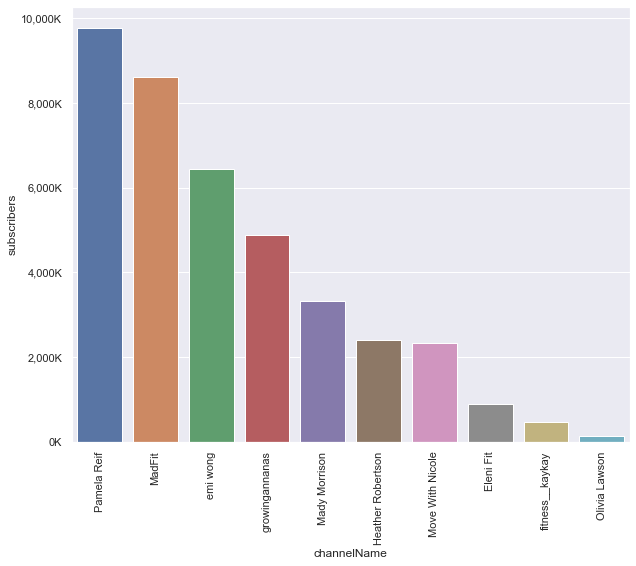

In [25]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='channelName', y='subscribers', data=channel_data.sort_values('subscribers', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

Next, we will look at the number of views for each channel. Some channels remain the same positions such as Mady Morrison, Heather Robertson, Move with Nicole. Although Pamela Reif has the most subscribers, growingannanas has more views. This may due to the fact that growingannanas has more videos than Pamela Reif. So, let's check the average view number for each video. 

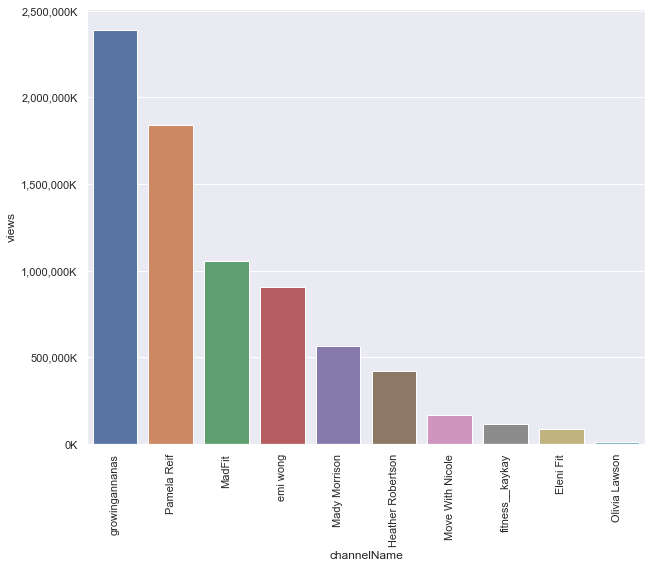

In [26]:
ax = sns.barplot(x='channelName', y='views', data=channel_data.sort_values('views', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

In [27]:
# Add an average views column
channel_data['averageViews'] = channel_data['views'] // channel_data['totalVideos'] 

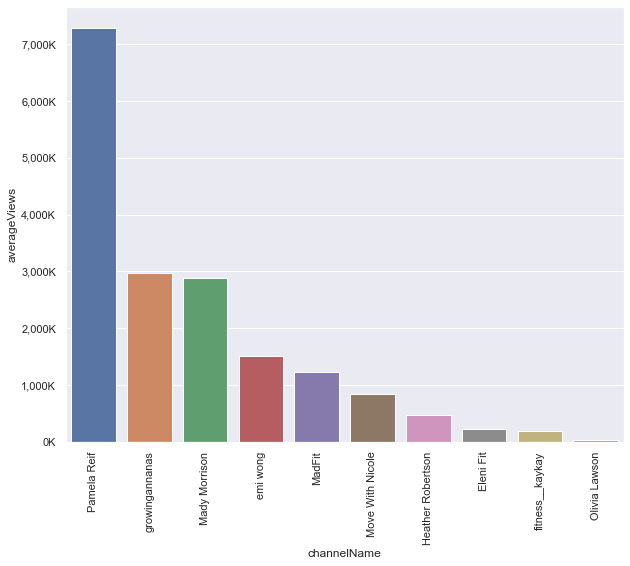

In [28]:
ax = sns.barplot(x='channelName', y='averageViews', data=channel_data.sort_values('averageViews', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

The average views number of Pamela Reif outweights other channels and interestingly, Mady Morrison has the third largest average views number although the channel ranks 5th in number of subscribers and views.

### Get video statistics for all the channels

In the second step, we will obtain the video statistics for all the channels. In total, we obtained 5,098 videos as seen in below.

In [29]:
# Create a dataframe with video statistics and comments from all channels

video_df = pd.DataFrame()
comments_df = pd.DataFrame()

for c in channel_data['channelName'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = channel_data.loc[channel_data['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    
    # get video data
    video_data = get_video_details(youtube, video_ids)
    # get comment data
    comments_data = get_comments_in_videos(youtube, video_ids)

    # append video data together and comment data toghether
    video_df = video_df.append(video_data, ignore_index=True)
    comments_df = comments_df.append(comments_data, ignore_index=True)

Getting video information from channel: Move With Nicole
Getting video information from channel: Mady Morrison
Getting video information from channel: Pamela Reif
Could not get comments for video aI1GL0aUkmU
Could not get comments for video l4IKrZymsXU
Getting video information from channel: MadFit
Could not get comments for video VJ75BRoB24I
Getting video information from channel: Eleni Fit
Getting video information from channel: Olivia Lawson
Could not get comments for video p2pOxmA8mFk
Could not get comments for video 3MTrNB7ZZNI
Could not get comments for video 2A3TlBVWECA
Getting video information from channel: growingannanas
Could not get comments for video jstfsT5MK3o
Getting video information from channel: Heather Robertson
Getting video information from channel: emi wong
Could not get comments for video NJZ95sZlXL4
Getting video information from channel: fitness__kaykay
Could not get comments for video W9VFnKQUSjo


In [34]:
video_df[-10:]

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
5089,vRqUrAiKWnQ,fitness__kaykay,20 MIN FULL BODY HIIT WORKOUT + 5 MIN CORE FIN...,"Gyms are closed again. No problem, here we go ...","['fitness', 'homeworkout', 'crossfit', 'functi...",2020-11-02T19:38:39Z,37188.0,1221.0,NaN,126.0,PT25M14S,hd,False
5090,HUAZw-KzWGE,fitness__kaykay,20 MIN FULL BODY DUMBBELL WORKOUT | CROSSFIT® ...,Hey my #everydaywarrior crew! Are you ready fo...,"['crossfit', 'functionaltraining', 'functional...",2020-10-07T17:27:35Z,32115.0,860.0,NaN,83.0,PT24M27S,hd,False
5091,rEjA4y4IdaM,fitness__kaykay,Challenge time: Italy 🇮🇹 vs. Germany 🇩🇪 & Aus...,"Da ist sie endlich, die Challenge - aus Berlin...","['fitness', 'functionalfitness', 'homeworkout'...",2020-09-10T16:30:11Z,8067.0,271.0,NaN,19.0,PT12M,hd,False
5092,kXR7HW-D5F0,fitness__kaykay,Influencer schieben Welle ! VLOG Berlin Foodsp...,Der versprochene 2. Teil aus Berlin. Viel Spaß...,"['fitness', 'functionalfitness', 'homeworkout'...",2020-08-20T17:00:09Z,8229.0,217.0,NaN,16.0,PT7M57S,hd,False
5093,1fhg__Qcrbk,fitness__kaykay,Was machen Fitness - Influencer wirklich? VLOG...,Berlintrip – VLOG mit dem Foodspring-Team\nSei...,"['fitness', 'functionalfitness', 'homeworkout'...",2020-08-11T17:00:11Z,6649.0,208.0,NaN,28.0,PT11M19S,hd,False
5094,CGxhrAl4tSE,fitness__kaykay,10 MIN BOOTY WORKOUT by Pamela Reif! Halte ich...,10 Minuten kurz und knackiges BOOTY WORKOUT vo...,"['fitness', 'functionaltraining', 'pamelareif'...",2020-07-15T16:00:11Z,22553.0,557.0,NaN,39.0,PT13M30S,hd,False
5095,SDwWNaxW3KI,fitness__kaykay,30 MIN FULL BODY HIIT WORKOUT / HOMEWORKOUT ||...,"Let's get right into it, here we go, with one ...","['fitness', 'functionalfitness', 'homeworkout'...",2020-07-04T07:00:11Z,35301.0,1021.0,NaN,104.0,PT30M,hd,False
5096,BNGVpDQR36A,fitness__kaykay,Perfektes Frühstück || mein PROTEIN PORRIDGE R...,Hier seht ihr meine Lieblingsmahlzeit des Tage...,"['crossfit', 'food', 'healthy', 'recipe', 'oat...",2020-06-20T08:19:55Z,24049.0,575.0,NaN,45.0,PT9M40S,hd,False
5097,xPl82vdhiro,fitness__kaykay,15 MIN ABS / CORE WORKOUT || No Equipment || F...,"You wanted it, so you get it: Since so many of...","['abs', 'crossfit', 'core', 'fitness', 'strong...",2020-06-14T07:00:12Z,42546.0,1293.0,NaN,134.0,PT14M45S,hd,False
5098,QbedDwH2mIU,fitness__kaykay,Mein erstes Mal - JETZT ENDLICH YOUTUBE - We...,Hey ich bin KayKay!\nIch erkläre warum ich nun...,"['fitness', 'crossfit', 'functionaltraining', ...",2020-06-06T08:00:10Z,26137.0,914.0,NaN,124.0,PT12M10S,hd,False


In [31]:
# Write video data to CSV file for future references
video_df.to_csv('video_data_top10_channels.csv')
comments_df.to_csv('comments_data_top10_channels.csv')

In [32]:
# Read data 
video_df = pd.read_csv('video_data_top10_channels.csv', usecols = [1,2,3,4,5,6,7,8,9,10,11,12,13])

### Preprocessing & Feature engineering

To be able to make use of the data for analysis, we need to perform a few pre-processing steps. Firstly, I would like reformat some columns, especially the date and time columns such as "pushlishedAt" and "duration". In addition, I also think it is necessary to enrich the data with some new features that might be useful for understanding the videos' characteristics.

#### Check for missing values

In [35]:
video_df.isna().sum()

video_id             0
channelTitle         0
title                0
description        686
tags               950
publishedAt          0
viewCount            1
likeCount          131
favouriteCount    5099
commentCount         1
duration             0
definition           0
caption              0
dtype: int64

#### Check date values

In [36]:
video_df.publishedAt.sort_values().value_counts()

2022-03-16T02:00:12Z    2
2022-01-08T02:00:09Z    2
2022-05-18T01:00:09Z    2
2022-07-20T01:00:09Z    2
2020-09-09T14:00:11Z    2
                       ..
2020-05-15T14:00:08Z    1
2019-12-08T08:00:05Z    1
2023-07-26T02:00:11Z    1
2023-09-14T17:30:38Z    1
2022-12-22T14:59:53Z    1
Name: publishedAt, Length: 5089, dtype: int64

#### Check data types

In [37]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   video_id        5099 non-null   object 
 1   channelTitle    5099 non-null   object 
 2   title           5099 non-null   object 
 3   description     4413 non-null   object 
 4   tags            4149 non-null   object 
 5   publishedAt     5099 non-null   object 
 6   viewCount       5098 non-null   float64
 7   likeCount       4968 non-null   float64
 8   favouriteCount  0 non-null      float64
 9   commentCount    5098 non-null   float64
 10  duration        5099 non-null   object 
 11  definition      5099 non-null   object 
 12  caption         5099 non-null   bool   
dtypes: bool(1), float64(4), object(8)
memory usage: 483.1+ KB


I see that some columns need to change data types to integer. In the ext step, I will convert object type to integer.

In [38]:
cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[cols] = video_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

#### Enriching data

To answer my questions regarding the objective of this project, I will add some columns for further analysis:
- create a new day name column (name of day in a week)
- create a year column
- convert duration to seconds 
- calculate number of tags for each posted video
- calculate the length of the title
- calculate comments and likes per 1000 view ratio

In [39]:
# Create published day name column
video_df['publishedAt'] =  video_df['publishedAt'].apply(lambda x: parser.parse(x)) # Parse a string into datetime object (default)
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [40]:
# Create year column
video_df['Year'] = video_df['publishedAt'].apply(lambda x: x.strftime("%Y")) 

In [41]:
# Convert duration to seconds
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x)) # create ISO duration strings format PnnYnnMnnDTnnHnnMnnS
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]') #convert timedelta64 to seconds

In [42]:
def count_words(text):
    words = str(text).split(", ")
    return len(words)

In [43]:
# Calculate number of tags
video_df['tags'] = video_df['tags'].fillna(0)
video_df['tagsCount'] = video_df['tags'].apply(count_words)

In [44]:
# Title character length
video_df['titleLength'] = video_df['title'].apply(lambda x: len(x))

In [45]:
# Comments and likes per 1000 view ratio
video_df['likeRatio'] = video_df['likeCount']/ video_df['viewCount'] * 1000
video_df['commentRatio'] = video_df['commentCount']/ video_df['viewCount'] * 1000

In [47]:
video_df[:10]

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,Year,durationSecs,tagsCount,titleLength,likeRatio,commentRatio
0,K2hACMvdHyk,Move With Nicole,20 MIN EXPRESS PILATES WORKOUT || At-Home Inte...,Get ready to move with this Express Pilates Wo...,"['pilates workout full body', 'pilates workout...",2023-12-20 11:37:48+00:00,411114.0,13462.0,NaN,339.0,PT24M11S,hd,False,Wednesday,2023,1451.0,22,77,32.745175,0.824589
1,KBYMkYXS_oM,Move With Nicole,Afternoon yoga feels 🤍 #yogateacher #yoga #yog...,NaN,0,2023-12-13 03:02:12+00:00,55599.0,4401.0,NaN,52.0,PT34S,hd,False,Wednesday,2023,34.0,1,55,79.156100,0.935269
2,-y69N0qV94E,Move With Nicole,Pilates Tip: Spinal Position In Plank 🤍 #pilates,NaN,0,2023-12-05 11:44:37+00:00,36996.0,2235.0,NaN,19.0,PT24S,hd,False,Tuesday,2023,24.0,1,48,60.411936,0.513569
3,Q98t9cbp-xo,Move With Nicole,35 MIN UPPER BODY & CORE WORKOUT || At-Home Pi...,Get ready to strengthen your upper body and co...,"['move with nicole', 'abs workout no equipment...",2023-12-04 11:37:13+00:00,214411.0,9527.0,NaN,283.0,PT36M42S,hd,False,Monday,2023,2202.0,21,66,44.433355,1.319895
4,_y39T5jQfFM,Move With Nicole,25 MIN FEEL GOOD PILATES || At-Home Pilates Wo...,Connect with your breath and your body in this...,"['pilates workout full body', 'full body pilat...",2023-11-16 14:26:54+00:00,487783.0,18773.0,NaN,500.0,PT26M58S,hd,False,Thursday,2023,1618.0,22,66,38.486376,1.025046
5,SV3NGECQjXc,Move With Nicole,Sometimes 20 minutes of mindful movement is al...,NaN,"['pilates', 'move with nicole']",2023-11-09 05:14:32+00:00,102686.0,8064.0,NaN,51.0,PT15S,hd,False,Thursday,2023,15.0,2,72,78.530666,0.496660
6,-_6uhR46pvE,Move With Nicole,20 MIN EXPRESS PILATES WORKOUT || Power Pilate...,Get ready to move with this Express Power Pila...,"['pilates workout full body', 'pilates workout...",2023-11-02 10:46:53+00:00,463053.0,16611.0,NaN,476.0,PT24M33S,hd,False,Thursday,2023,1473.0,23,82,35.872783,1.027960
7,dqIZnyUtKXI,Move With Nicole,25 MIN MORNING YOGA FLOW || Energising Yoga Fl...,Start your day right with this 25 Minute Morni...,"['morning yoga', 'morning yoga flow', 'move wi...",2023-10-17 11:50:55+00:00,262313.0,10969.0,NaN,317.0,PT26M35S,hd,False,Tuesday,2023,1595.0,24,66,41.816456,1.208480
8,lNftFawOAUM,Move With Nicole,30 MIN FULL BODY WORKOUT || At-Home Pilates (N...,Work the entire body with this 30 Minute Moder...,"['pilates workout full body', 'pilates workout...",2023-10-04 09:18:37+00:00,940115.0,26989.0,NaN,649.0,PT35M45S,hd,False,Wednesday,2023,2145.0,22,58,28.708190,0.690341
9,dOO6-o7ObnU,Move With Nicole,40 MIN FULL BODY WORKOUT || Power Pilates With...,Work the entire body with this 40 Minute Full ...,"['pilates workout full body', 'full body pilat...",2023-09-06 12:11:41+00:00,504002.0,16916.0,NaN,719.0,PT44M16S,hd,False,Wednesday,2023,2656.0,22,69,33.563359,1.426582


## Exploratory analysis

### Views distribution per channel

First, let's take a look at the distribution of views per channel. It can be seen that some channels have a small but stable number of views such as Olivia Lawson, Eleni Fit, Heather Robertson. Channels with more variance in their views are Mady Morrison, Emi Wong, growingannanas. Pamela Reif has the largest viewewship distribution.

<AxesSubplot:xlabel='viewCount', ylabel='channelTitle'>

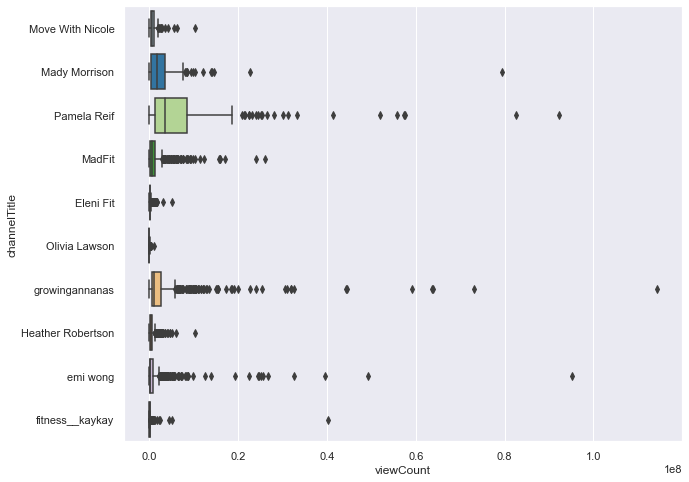

In [48]:
sns.boxplot(y="channelTitle", x="viewCount", data=video_df, palette='Paired')

Let's deep dive into the dataset and see which year each channel has the most views.

In [49]:
# Calculate total number of views per year for each channel
views_df = video_df.pivot_table(index = "channelTitle", 
                                columns = "Year", 
                                values = "viewCount", aggfunc='sum').fillna(0).astype(int)
views_df

Year,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
channelTitle,,,,,,,,,,
Eleni Fit,0,0,0,0,0,0,14689935,38215651,32269061,189396
Heather Robertson,447990,2457801,2932093,21816157,97090944,121777744,92463017,50304278,31611148,299624
MadFit,0,0,0,77737217,200755742,420735203,149277797,144568139,63723246,499844
Mady Morrison,23294325,56456043,72888310,51930537,68425650,174723574,63726543,41212439,14950562,0
Move With Nicole,0,0,0,0,3705918,54608210,45544805,37280883,24804681,0
Olivia Lawson,0,0,0,0,0,83076,5231353,5465271,3785054,23084
Pamela Reif,0,21458491,0,236133555,238813141,877912997,306546203,106235890,55538765,285276
emi wong,0,0,67482167,186319046,178245475,330320358,55415288,47646487,38487618,202121
fitness__kaykay,0,0,0,0,0,884448,14672539,20313917,77662098,158760


<AxesSubplot:xlabel='Year', ylabel='channelTitle'>

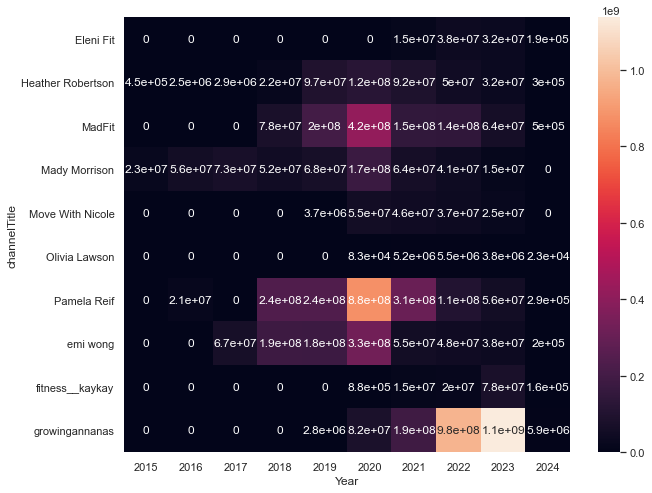

In [50]:
sns.heatmap(views_df, annot = True)

According to the heatmap:
- 2020 is the most successful year for Heather Robertson, MadFit, Mady Morrison, Move with Nicole, Pamela Reif and emi wong in terms of views.
- In 2022, videos of Eleni Fit and Olivia Lawson reach the most viewers
- growingannanas and fitness_kaykay attract most views in 2023

### Does the number of likes and comments affect the number of views?

Firstly, I want to check the correlation between the number of likes, comments and the number of views. From the scatterplot below, the number of likes and comments seems related with the number of views. The number of likes suggests stronger correlation with the number of views than the number of comments.

<AxesSubplot:xlabel='commentCount', ylabel='viewCount'>

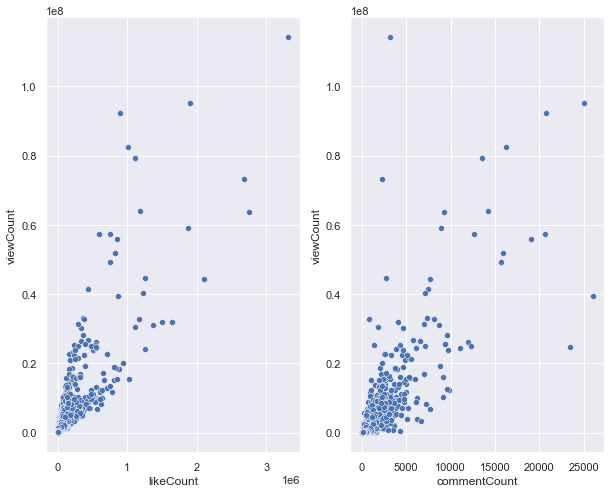

In [51]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "likeCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "commentCount", y = "viewCount", ax=ax[1])

Now we will take a look at the correlation if we look at the comment ratio and like ratio instead of the absolute number.

<AxesSubplot:xlabel='commentRatio', ylabel='viewCount'>

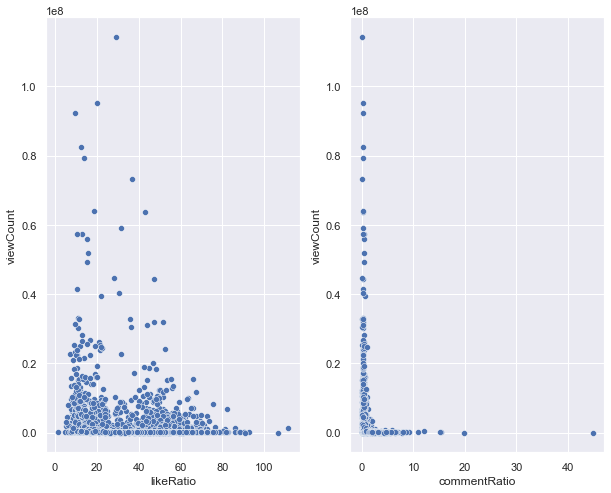

In [52]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "likeRatio", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "commentRatio", y = "viewCount", ax=ax[1])

It turns out that the correlation is much less clear when we transfer to the ratio. 

We can see some positive correlation between views and like ratio (though very subtle), which means that if a video has a broadrer view, it will receive more likes. In the contrary, a video with a higher number of likes may be more appealing to potential viewers, contributing to more views.

The comment-view relationship seems to completely disappear: many videos have millions of views but very few comments, while some videos have very few views but better interactions. However, it is understandable that comments take more effort than views and likes, and normally there are fewer comments if the video was released long time ago.

### Does the video duration have an impact to the views and interactions?

The histogram belows describe the distribution of video length. I limit the duration to 1.2 hour because most fitness video are about 1 hour. Other longer videos are probably streaming exercises video. Most videos are from 10 seconds to 2000 seconds, which is around 30 minutes.

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

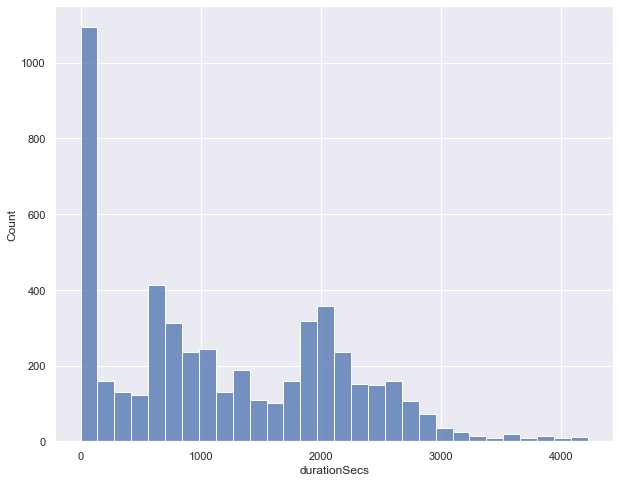

In [53]:
sns.histplot(data=video_df[video_df['durationSecs'] < 1.2*3600], x="durationSecs", bins=30)

<AxesSubplot:xlabel='durationSecs', ylabel='commentCount'>

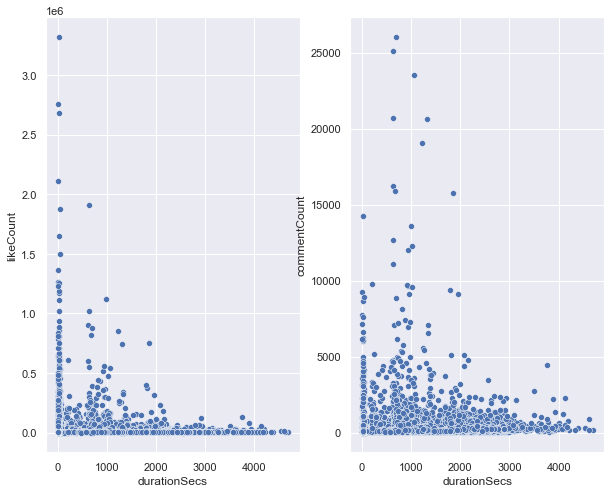

In [54]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "durationSecs", y = "likeCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "durationSecs", y = "commentCount", ax=ax[1])

It can be easily see that short videos get more interactions (likes and comments) than long videos. The correlation between number of likes and duration is clearer than  that of number of comments and duration.

### Does the length of video title affect the views?

There is no clear correlation between the length of title and the number of views. On average, each video has 66 characters. The most viewed videos have 40 to 80 characters.

<AxesSubplot:xlabel='titleLength', ylabel='viewCount'>

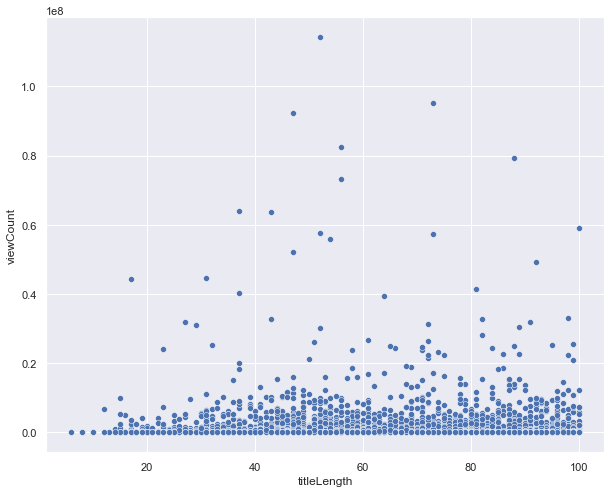

In [55]:
sns.scatterplot(data = video_df, x = "titleLength", y = "viewCount")

In [56]:
median_title = np.median(video_df.titleLength)
average_title = np.mean(video_df.titleLength)

In [57]:
print(f"Median: {median_title}")
print(f"Average (Mean): {average_title}")

Median: 66.0
Average (Mean): 66.27221023730144


### Does title with the most popular words have more views and interactions?

First, let's see which words frequently appeared in the titles. I will create a word cloud for the most common words.

In [58]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

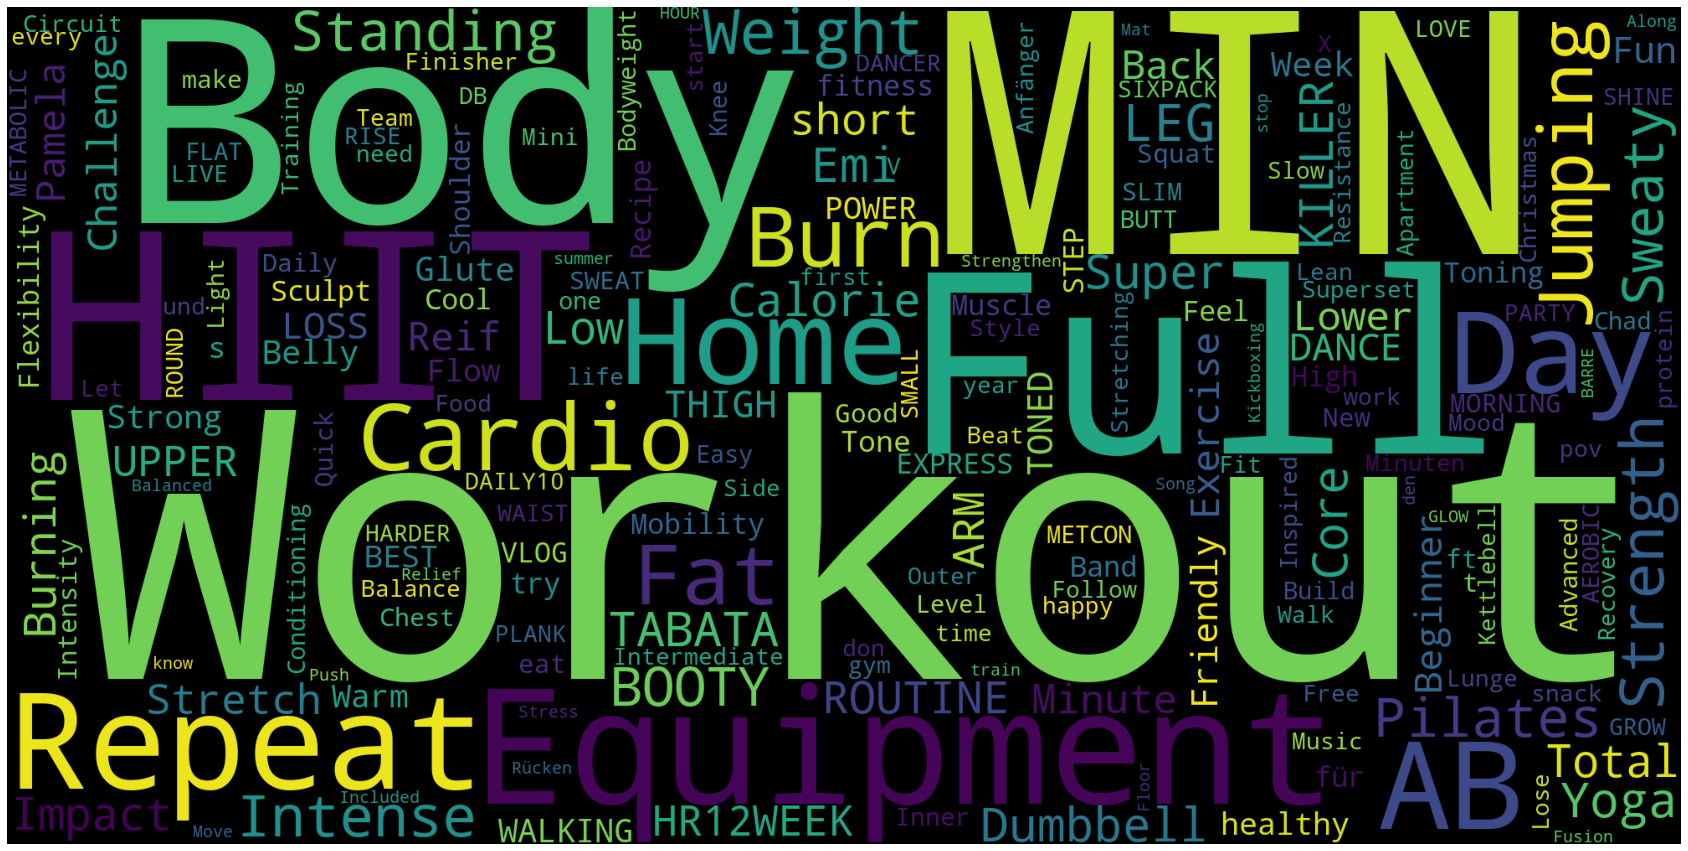

In [59]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

In [60]:
def contains_keywords(word):
    """
    Check if the given string contains any of the specified keywords.

    Parameters:
    - word (str): The input string to check.

    Returns:
    - bool: True if any keyword is found, False otherwise.
    """
    keywords = ["min", "body", "full", "workout", "hiit"]
    return any(keyword in word.lower() for keyword in keywords)

In [61]:
# Add column to check whether the title include the most frequently appeared words
video_df['contains_keywords']= video_df['title'].apply(contains_keywords)

In [62]:
video_df.pivot_table(index = "contains_keywords", 
                     values = ["likeCount", "commentCount"],
                    aggfunc = "sum").astype(int).reset_index()

,contains_keywords,commentCount,likeCount
0,False,557950,92509920
1,True,2125394,98003345


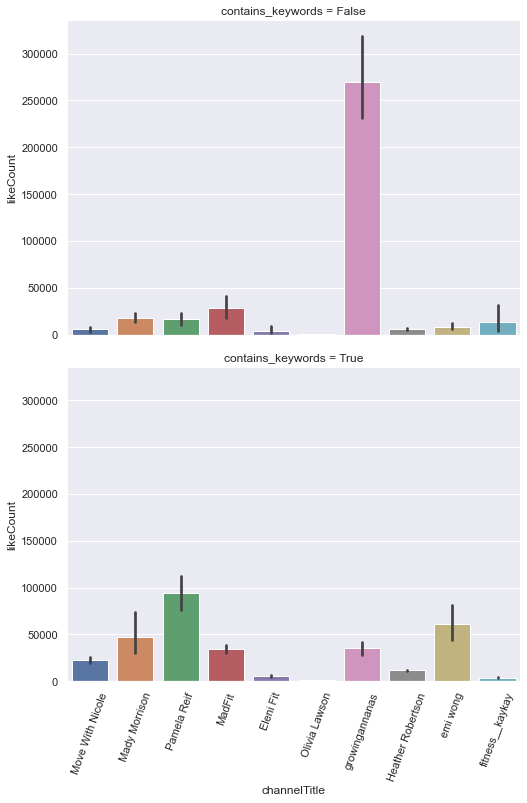

In [63]:
g = sns.catplot(data = video_df, x = "channelTitle", y = "likeCount", row = "contains_keywords",
           kind="bar", height=5, aspect=1.5)
g.set_xticklabels(rotation = 70)

All youtubers with the most common words in title reached more views than other words in title, except for growingannanas and fitness__kaykay.
Let's see which words appeared most in their video with the most likes.

In [64]:
annanas_df = video_df[video_df.channelTitle == "growingannanas"]

In [65]:
annanas_df.sort_values(['likeCount'], ascending = False)[:15]

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,...,caption,pushblishDayName,Year,durationSecs,tagsCount,titleLength,likeRatio,commentRatio,title_no_stopwords,contains_keywords
2413,UIfjsWym7Qg,growingannanas,watermelon jelly? I had to try it and it taste...,NaN,0,2023-06-22 17:26:39+00:00,114222770.0,3317675.0,NaN,3106.0,...,False,Thursday,2023,24.0,1,52,29.045654,0.027192,"[watermelon, jelly?, I, try, tastes, bomb]",False
2597,-iHCOK0Yo9E,growingannanas,yes GO FOR IT 🙌 #fitness #fitnessmotivation,NaN,0,2022-11-02 08:24:57+00:00,63710104.0,2755026.0,NaN,9253.0,...,False,Wednesday,2022,10.0,1,43,43.243157,0.145236,"[yes, GO, FOR, IT, 🙌, #fitness, #fitnessmotiva...",False
2353,hCDkdFDBYLk,growingannanas,this is THE BEST STRAWBERRY LEMON sorbet I‘ve ...,NaN,0,2023-08-27 17:44:08+00:00,73152699.0,2678254.0,NaN,2261.0,...,False,Sunday,2023,27.0,1,56,36.611828,0.030908,"[THE, BEST, STRAWBERRY, LEMON, sorbet, I‘ve, e...",False
2568,e1IkRnCaVDM,growingannanas,powerful habits ✨,NaN,0,2022-12-11 09:19:40+00:00,44389054.0,2106629.0,NaN,7622.0,...,False,Sunday,2022,18.0,1,17,47.458299,0.171709,"[powerful, habits, ✨]",False
2790,4BhWEtNGxao,growingannanas,#fitnesstransformation now it’s your turn. Wha...,NaN,0,2022-01-05 05:41:52+00:00,59170260.0,1877596.0,NaN,8899.0,...,False,Wednesday,2022,49.0,1,100,31.732090,0.150396,"[#fitnesstransformation, it’s, turn., Whatever...",False
2590,8y4VDIvVkL4,growingannanas,watch to see what happens if you don‘t quit an...,NaN,0,2022-11-09 12:00:33+00:00,31974271.0,1649557.0,NaN,4035.0,...,False,Wednesday,2022,30.0,1,91,51.590136,0.126195,"[watch, see, happens, don‘t, quit, start, beli...",False
2401,oOtUIDs7gwI,growingannanas,the NO KNIFE #pineapplehack,NaN,0,2023-07-03 18:06:15+00:00,31815273.0,1500790.0,NaN,4082.0,...,False,Monday,2023,48.0,1,27,47.171998,0.128303,"[NO, KNIFE, #pineapplehack]",False
2760,zBEgoOhBXmY,growingannanas,Healthy Food is NOT BORING! 💙,NaN,0,2022-03-18 09:21:57+00:00,31104543.0,1367672.0,NaN,8639.0,...,False,Friday,2022,16.0,1,29,43.970169,0.277741,"[Healthy, Food, NOT, BORING!, 💙]",False
2527,XR6NGiCI1Ao,growingannanas,healthy means BALANCE 🤍,NaN,0,2023-02-07 18:25:46+00:00,24049447.0,1260423.0,NaN,3873.0,...,False,Tuesday,2023,14.0,1,23,52.409646,0.161043,"[healthy, means, BALANCE, 🤍]",False
2653,lJ4Ty2Xos08,growingannanas,the most FUN WATERMELON project,NaN,0,2022-08-23 07:03:14+00:00,44515579.0,1257856.0,NaN,2688.0,...,False,Tuesday,2022,19.0,1,31,28.256535,0.060383,"[FUN, WATERMELON, project]",False


We can clearly see that most liked videos from youtuber growingannanas are short videos relating to food and motivation rather than workout videos.

In [66]:
kaykay_df = video_df[video_df.channelTitle == "fitness__kaykay"]

In [67]:
kaykay_df.sort_values(['likeCount'], ascending = False)[:15]

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,...,caption,pushblishDayName,Year,durationSecs,tagsCount,titleLength,likeRatio,commentRatio,title_no_stopwords,contains_keywords
4583,Vqzw3wtgMIA,fitness__kaykay,Gravity who? 💜🙆🏼‍♀️👀 #pushupchallenge,NaN,0,2023-09-05 18:19:52+00:00,40219051.0,1229880.0,NaN,7145.0,...,False,Tuesday,2023,8.0,1,37,30.579538,0.177652,"[Gravity, who?, 💜🙆🏼‍♀️👀, #pushupchallenge]",False
4618,uEOPuYkW7bQ,fitness__kaykay,Get smooth hips with these four moves. Are you...,1️⃣Harder: Cossack Squat + International Rotat...,0,2023-07-12 08:32:49+00:00,5041513.0,185346.0,NaN,441.0,...,False,Wednesday,2023,17.0,1,96,36.763964,0.087474,"[Get, smooth, hips, four, moves., Are, team, h...",False
4691,VBcVt3ImmdY,fitness__kaykay,Intense Abs & Cardio. Details in description 🫶...,Intense ABS & CARDIO \n2-3 ROUNDS\n• watch the...,0,2023-03-23 14:31:14+00:00,4378079.0,105067.0,NaN,1090.0,...,False,Thursday,2023,17.0,1,72,23.998425,0.248968,"[Intense, Abs, &, Cardio., Details, descriptio...",True
4709,hfFe-bAGNAk,fitness__kaykay,If I can do it. You can do it too! ❤️🙏🏼 #heali...,#eatingdisorder #essstörung #recovery #healing,0,2023-03-06 16:39:51+00:00,2214284.0,92218.0,NaN,444.0,...,False,Monday,2023,15.0,1,72,41.646871,0.200516,"[If, I, it., You, too!, ❤️🙏🏼, #healing, #eatin...",False
4620,aI3eJ-qTOKQ,fitness__kaykay,ABS | core for everyone 🔥✨It’s always a beauti...,Strong core is key - start to work on that and...,0,2023-07-10 16:59:51+00:00,2433127.0,72521.0,NaN,246.0,...,False,Monday,2023,16.0,1,97,29.805678,0.101104,"[ABS, |, core, everyone, 🔥✨It’s, always, beaut...",False
4922,DNCNNIsmRos,fitness__kaykay,#relateable Part 1 (more to come 😁). What are ...,NaN,0,2022-04-02 15:23:39+00:00,1645951.0,54957.0,NaN,500.0,...,False,Saturday,2022,16.0,1,88,33.389208,0.303776,"[#relateable, Part, 1, (more, come, 😁)., What,...",True
4571,uLNHSwUwMvQ,fitness__kaykay,Gravity who? 😅🤯🤔..way harder than it looks. 😮‍💨🔥,NaN,0,2023-10-06 15:47:22+00:00,1071131.0,35679.0,NaN,371.0,...,False,Friday,2023,9.0,1,48,33.309651,0.346363,"[Gravity, who?, 😅🤯🤔..way, harder, looks., 😮‍💨🔥]",False
4670,tMCdsA70OiY,fitness__kaykay,I am obsessed ! 😮‍💨🤤 The easiest healthy prote...,"Sweet tooth? ✨ No problem, I hear you. \n\nI c...",0,2023-04-21 21:12:50+00:00,839440.0,35013.0,NaN,206.0,...,False,Friday,2023,30.0,1,91,41.709949,0.245402,"[I, obsessed, !, 😮‍💨🤤, The, easiest, healthy, ...",False
4719,SxcAZ-6dQwo,fitness__kaykay,To me a fit body also comes with a healthy and...,#fitbody #fitnessmotivation #earn \n\nAnd when...,0,2023-02-20 20:50:48+00:00,797530.0,31463.0,NaN,324.0,...,False,Monday,2023,17.0,1,91,39.450554,0.406254,"[To, fit, body, also, comes, healthy, strong, ...",True
4781,vuKnZIjNgkA,fitness__kaykay,Know and feel the difference! DEADLIFT vs. RDL...,Do you know the difference between deadlifts a...,0,2022-12-11 18:23:32+00:00,838883.0,26734.0,NaN,117.0,...,False,Sunday,2022,19.0,1,65,31.868568,0.139471,"[Know, feel, difference!, DEADLIFT, vs., RDL, ...",False


Most liked videos from youtuber fitness_kaykay are short videos relating to workout challenges or tips and motivations.

### Does number of tags affect the view count?

It seems that most videos have between 20 and 40 tags. The relationship between number of tags and view count is not clearly seen.

<AxesSubplot:xlabel='tagsCount', ylabel='viewCount'>

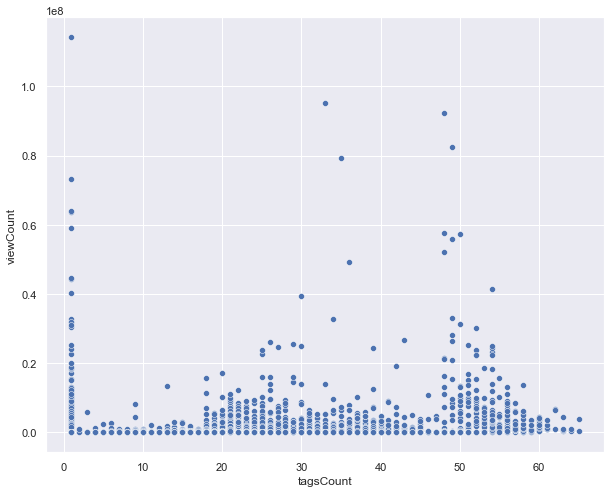

In [68]:
sns.scatterplot(data = video_df, x = "tagsCount", y = "viewCount")

### Which day in the week are most videos uploaded?

Most videos are uploaded on Wednesday whereas Saturday has the least uploaded videos.

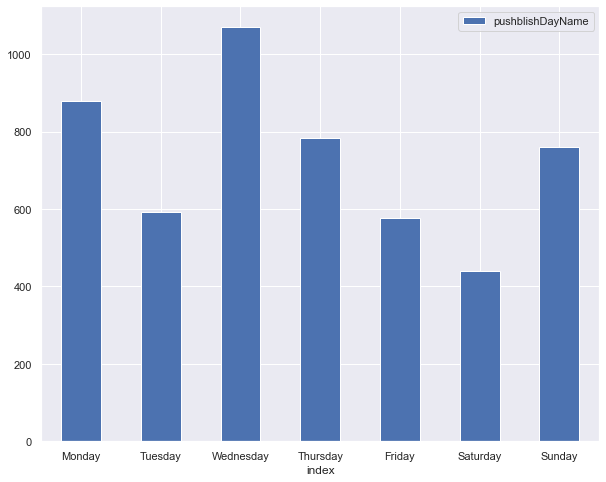

In [69]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)

I want to know the uploading schedule of each channels. From the heatmap below:
- Eleni Fit usually uploads video on Monday and Thursday
- Heather Robertson and Mady Morrison have most videos uploaded on Sunday
- MadFit uploads videos on Monday, Thursday and Friday
- Move with Nicole uploads videos on Thursday
- Olivia Lawson has most videos uploaded on Monday
- Pamela Reif and emi wong upload videos on Wednesday
- fitness_kaykay uploads videos regularly on Wednesday and Sunday
- growingannanas has videos uploaded on Monday and Saturday

In [70]:
channels_uploaded = video_df.pivot_table(index = "channelTitle", 
                                         columns = "pushblishDayName" ,
                                         values = "video_id", aggfunc = 'count').fillna(0).astype(int)
channels_uploaded = channels_uploaded[weekdays]
channels_uploaded

pushblishDayName,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
channelTitle,,,,,,,
Eleni Fit,114,10,91,121,9,11,22
Heather Robertson,135,123,158,131,97,61,167
MadFit,167,119,154,167,168,45,35
Mady Morrison,24,26,19,19,8,5,96
Move With Nicole,20,32,57,74,6,3,6
Olivia Lawson,94,39,58,68,70,18,16
Pamela Reif,10,32,105,14,37,26,30
emi wong,58,48,187,62,55,33,157
fitness__kaykay,71,60,131,59,49,67,142


<AxesSubplot:xlabel='pushblishDayName', ylabel='channelTitle'>

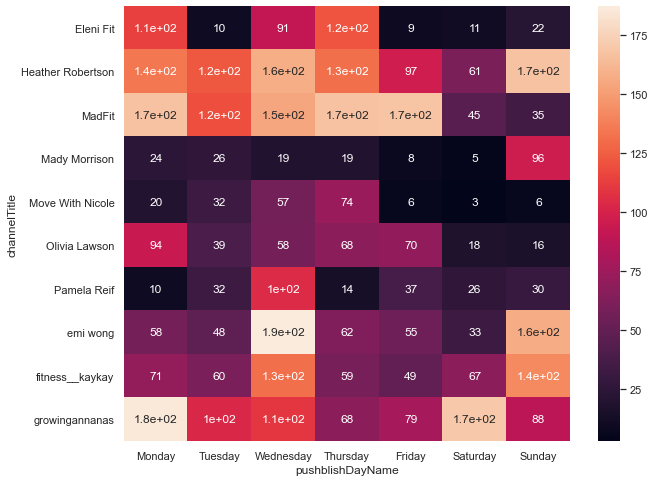

In [71]:
sns.heatmap(channels_uploaded, annot = True)

Let's see which uploaded day in the week have the most interactions. Regarding the table below, Sunday uploaded video has the most views and like. Based on number of comments, videos uploaded on Wednesday have the most comments. However, the number of interactions may depend on other factors like content, title, how long the video has been posted, the video length etc. 

In [72]:
weekdays_viewCount = video_df.pivot_table(index = "pushblishDayName", 
                     values = ["viewCount", "likeCount", "commentCount"],
                    aggfunc = "sum").astype(int).reset_index().sort_values(['viewCount'], ascending = False)
weekdays_viewCount 

,pushblishDayName,commentCount,likeCount,viewCount
3,Sunday,549282,39337607,1784706289
6,Wednesday,603578,39836252,1673801840
5,Tuesday,306571,26721890,942007441
1,Monday,393712,24532294,937560023
4,Thursday,334367,25192619,925169703
0,Friday,277942,19991024,777143361
2,Saturday,217892,14901579,523097982


### Wordcloud for words in comments

In [73]:
stop_words = set(stopwords.words('english'))
comments_df['comments_no_stopwords'] = comments_df['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comments_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

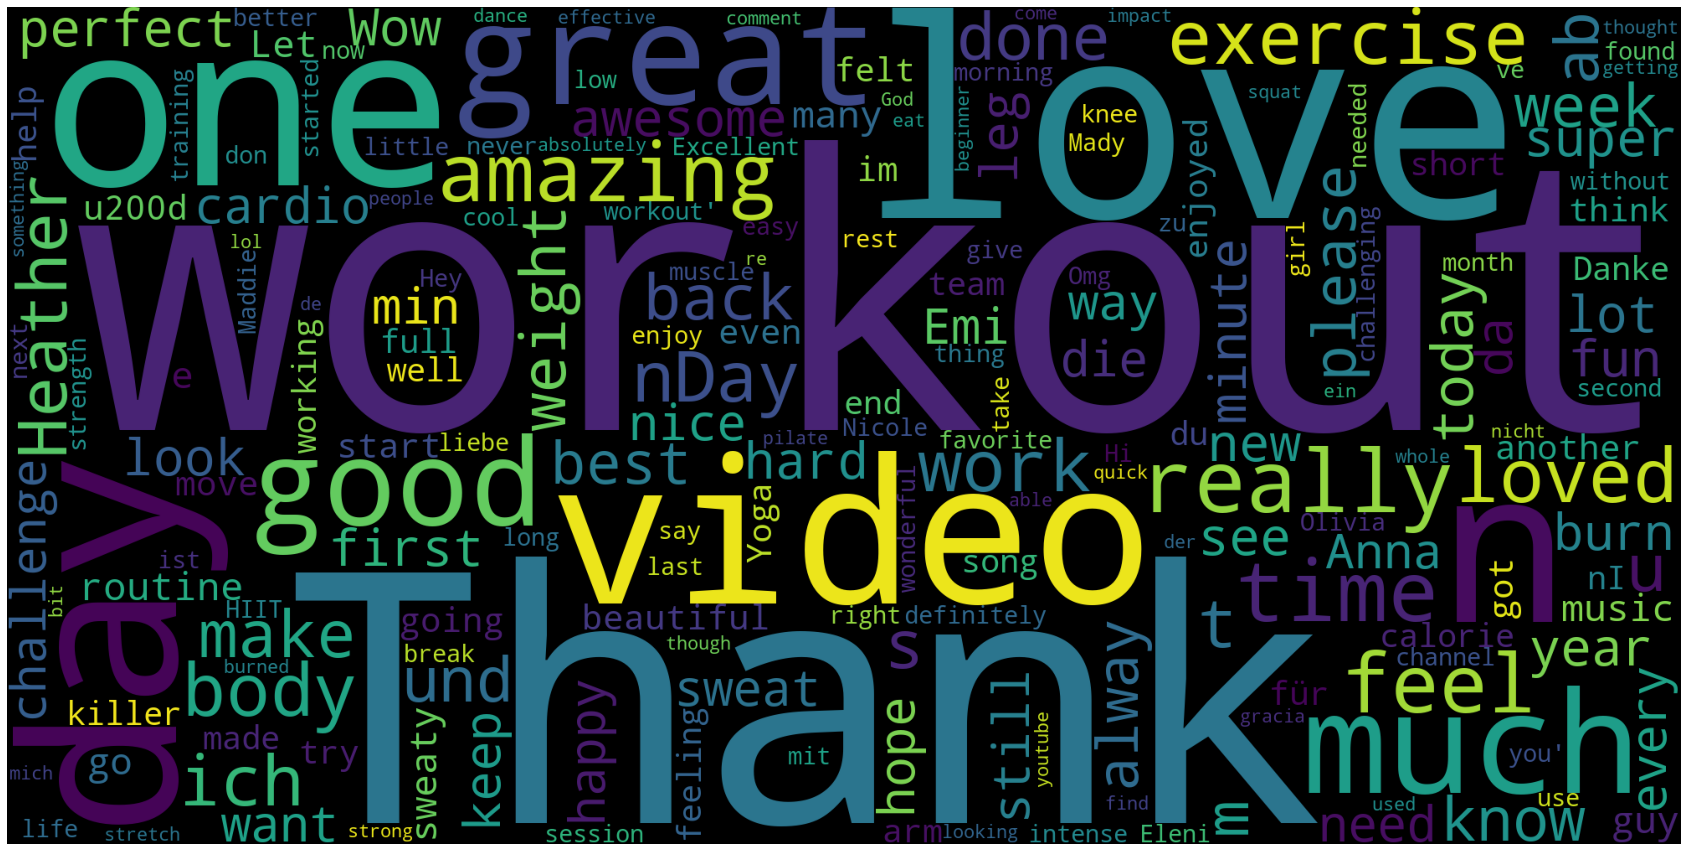

In [74]:
wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, 
                      collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

## Conclusions and future research ideas

In this project, we have explored the video data of the top 10 fqvorite fitness channels and uncovered many interesting findings:

- There is a correlation between the number of views and the number of interactions (likes and comments). 

- Short videos tend to get more interactions than long videos.

- Most-viewed videos tend to have average title length of 30-70 characters. Titles with the most popular words such as body, full, workout, hiit tend to have more views than other types of title, except for two channels growingannanas and fitness_kaykay

- Most videos have between 20 and 40 tags. There is no clear correlation between number of tags and number of views.

- Videos are usually uploaded on Mondays and Wednesday. Friday and Saturday are not the popular time to post a new video.

- Comments on videos are generally positive, with many appreciation and compliment words.

### References/ Resources used:
[1] Youtube API. Avaiable at https://developers.google.com/youtube/v3

[2] Exploratory Data Analysing Using Youtube Video Data from Most Popular Data Science Channels. https://github.com/thu-vu92/youtube-api-analysis/blob/main/Sample_project_youtube_videos_EDA.ipynb
